# Model Output Notebook

<img style="float:center;" src="https://arcticexpansion.vse.gmu.edu/sites/arcticexpansion.vsnet.gmu.edu/files/images/header5d2.png" width=600px>

### ADCIRC-SWAN Output


### Initialize Libraries

In [1]:
import warnings;warnings.filterwarnings("ignore")
import netCDF4 as nc4;        import pandas as pd
import requests;              import json;
import matplotlib as mpl;     import matplotlib.pyplot as plt
import matplotlib.tri as tri; import pathlib as pl
import cartopy.crs as ccrs;   import cartopy.io.img_tiles as cart_img
import cartopy as cart;       import cartopy.io.img_tiles as cimgt
import numpy as np;           import xarray as xr
import skill_metrics as sm;   import geopandas as gpd
from shapely import Polygon,Point,MultiPoint,LineString,MultiLineString;import shapely.vectorized
from sklearn.neighbors import BallTree
from scipy.stats import linregress

source $HOME/miniforge3/bin/activate

salloc --ntasks=5 --nodes=1 --partition=normal --time=10:00:00

### Defined Functions

In [2]:
def noaa_data(begin,end,station,vdatum='NAVD',interval='6',
                       form='json',t_zone='GMT',unit='metric',product='water_level'):
    '''
    This function is used to get the data from NOAA API
    :param begin: begin date of the data
    :param end: end date of the data
    :param station: noaa station id
    :param vdatum: vertical datum such as NAVD
    :param interval: interval of the data (6 minutes)
    :param form: format of the data (json)
    :param t_zone: time zone of the data (GMT)
    :param unit: unit of the data (metric)
    :param product: type of the data (water_level)
    '''
    api = f'https://tidesandcurrents.noaa.gov/api/datagetter?begin_date={begin}&end_date={end}&station={station}'\
         f'&product={product}&application=NOS.COOPS.TAC.WL&datum={vdatum}&interval={interval}&time_zone={t_zone}&units={unit}&format={form}'
    data = requests.get(url=api).content.decode()
    return data


def nearest(items, pivot):
    return min(items, key=lambda x: abs(x - pivot))

def point_lookup(model_lat:np.array, model_lon:np.array, satellite_lat:np.array, satellite_lon:np.array):
    tree = BallTree(np.deg2rad(np.c_[model_lat,model_lon]), metric='haversine')
    distances, indices = tree.query(np.deg2rad(np.c_[satellite_lat, satellite_lon]), k = 1)
    return distances*6371,indices


#### Data for this exercise can be found here
https://doi.org/10.17603/ds2-h0fw-2p96

Download the swan_HS.63.nc from one of the 4 folders

---

### Initialize path and read netcdf file

In [3]:
root = pl.Path('/groups/ORC-CLIMATE/fhrl_repo/Arctic_Database')

ncfile = nc4.Dataset(root / '2017' /'outputs' / 'fort.63.nc')

#### Read metadata within netcdf file

In [4]:
start = pd.to_datetime(ncfile.variables['time'].base_date)
dt = pd.date_range(start=start,freq='1h',periods=ncfile.dimensions['time'].size)

# read the lons and lats from netcdf file
x,y = ncfile.variables['x'][:],ncfile.variables['y'][:]

_____________________________________

In [5]:
stations = {'prudhoe':{'id':9497645,'lat':70.414987,'lon':-148.537066},
            'red':{'id':9491094,'lat':67.573874,'lon':-164.066624},
            'nome':{'id':9468756,'lat':64.486464,'lon':-165.450185},
            'unalakleet':{'id':9468333,'lat':63.881322,'lon':-160.820145},
            'paul':{'id':9464212,'lat':57.228635,'lon':-170.241801}}

In [6]:
name = 'nome'
station = stations[name]['id']
start,end = pd.to_datetime('2017-01-01 01:00').strftime('%Y%m%d %H:%M'),dt[-1].strftime('%Y%m%d %H:%M')#pd.to_datetime('2019-01-01 01:00').strftime('%Y%m%d %H:%M')
file = json.loads(noaa_data(start,end,station,vdatum='MSL',interval='6',product='hourly_height'))

obs =np.array([float(file['data'][i]['v']) if file['data'][i]['v']!='' else np.nan for i in range(len(file['data']))])
obs_dt = pd.to_datetime([file['data'][i]['t'] for i in range(len(file['data']))])

#### plot a map of the Hs at a specific time

In [6]:
shp_paths = pl.Path('/groups/ORC-CLIMATE/fhrl_repo/Arctic_Database/arctic_shapefiles')
communities = gpd.read_file(shp_paths / 'communities' /'City_Boundaries_wgs84.shp')
county = gpd.read_file(shp_paths / 'Alaska_Borough_and_Census_Area_Boundaries' /'Alaska_Borough_and_Census_Area_Boundaries.shp')
coastline = gpd.read_file(shp_paths / 'Alaska_Coastline' /'Alaska_Coastline.shp')

In [14]:
nodes = np.where((-10 < ncfile['depth'][:].data)&(ncfile['depth'][:].data < 5))[0]

In [ ]:
percentile_95 = np.nanpercentile(ncfile.variables['zeta'][::12,nodes.tolist()],95,axis=1)

In [ ]:
# map boundary ------------------------------------------------------------------------
lat1,lat2 = 58,71
lon1,lon2 = -172, -140

# defining the time range I want
#time1, time2 = np.datetime64('2024-10-11 21:00:00'),np.datetime64('2024-10-25 23:00:00')
# search for the nearest time to the time inputted
#idx = np.where((time1 < dt.values) &\
#               (dt.values < time2))[0]

: 

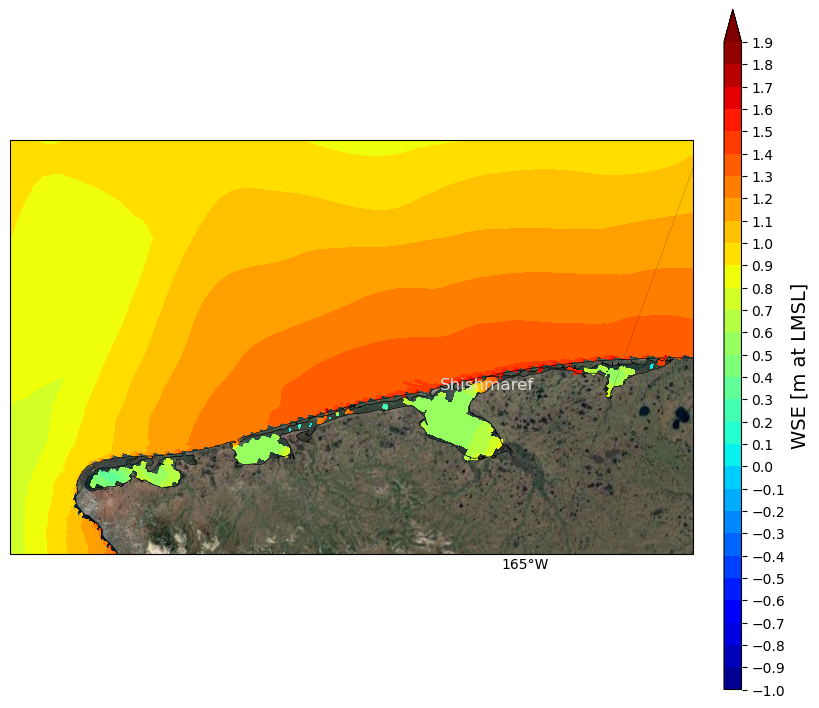

In [91]:
# plot parameters to initialize the plot
proj = ccrs.NorthPolarStereo(central_longitude=-145) # this data is in the arctic so we use the NorthPolarStereo projection
google_terrain = cimgt.GoogleTiles(style="satellite")
#proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(7,10))    
ax = plt.axes([0,0.,0.975,.975],projection=proj)
cmap = mpl.cm.get_cmap('jet')

# define countorus levels and colormap
levels = np.arange(-1.,2.,0.1)


# plot the model data on a map
# this is a triangular grid so we need to define the triangles
# and we need to use tricontourf to plot the data
triang = tri.Triangulation(x,y, triangles=ncfile.variables['element'][:,:]-1)
Z = np.max(ncfile['zeta'][idx,:],axis=0)
if Z.mask.any():
    point_mask_indices = np.where(Z.mask)
    tri_mask = np.any(np.in1d(ncfile.variables['element'][:,:]-1 , \
                              point_mask_indices).reshape(-1, 3), axis=1)
    triang.set_mask(tri_mask)
cf = ax.tricontourf(triang, Z,transform = ccrs.PlateCarree(),levels=levels, extend = 'max',cmap = cmap)

#Z = ncfile2['iceaf'][idx,:].data
#ice_level1 = [0,20,40,60,80,100]
#ice_level2 = np.arange(0.0,100.00000000,20)
#cf1 = ax.tricontour(triang, Z,transform = ccrs.PlateCarree(),levels=ice_level2,
#                            extend='max',cmap=mpl.cm.get_cmap('gist_gray'), linewidths = 1,zorder=2)#colors = '#f2f2f2'
# map parameters to make it look nice 

for c in range(len(communities)):
    cx,cy = communities.iloc[c].geometry.centroid.x,communities.iloc[c].geometry.centroid.y
    cname = communities.iloc[c]['CommunityN']
    if shapely.vectorized.contains(Polygon([(lon1,lat1),(lon1,lat2),(lon2,lat2),(lon2,lat1)]),cx,cy)==True:
        ax.text(cx,cy,cname,fontsize=12,transform=ccrs.PlateCarree(),color='#d9d9d9')
for c in range(len(coastline)):
    cx,cy = coastline.iloc[c].geometry.exterior.xy
    ax.plot(cx,cy,transform=ccrs.PlateCarree(),color='black',linewidth=0.5)
ax.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax.add_image(google_terrain, 8)
#ax.coastlines(resolution='10m',linewidth=0.5)
ax.add_feature(cart.feature.RIVERS,linestyle="-")
ax.add_feature(cart.feature.BORDERS.with_scale("50m"),linestyle="-")
gl = ax.gridlines(xlocs=np.arange(-190,-100,5),ylocs=np.arange(-90,90,3.5),
                            draw_labels=True,linewidth=0.3, color="black", alpha=0.5,
                            y_inline=False,linestyle="--",zorder=20)
gl.xlabels_top = False
gl.xlabels_bottom = True
gl.xlabel_style = {'rotation': 0}
gl.ylabels_left = False
gl.ylabels_right= True
gl.ylabel_style = {'rotation': -90}
gl.ypadding = 1.25
gl.xformatter = cart.mpl.gridliner.LONGITUDE_FORMATTER
gl.xpadding = 8

# add the colorbar
cbar_ax = fig.add_axes([1.02,.145,0.025,0.68])
cbar = fig.colorbar(cf,cax = cbar_ax, ticks=levels,orientation='vertical')
cbar.set_label(label = r'WSE [m at LMSL]',fontsize =14)
#cbar_ax2 = fig.add_axes([0.,-0.075,0.97,0.02])
#cbar = mpl.colorbar.ColorbarBase(cbar_ax2, cmap=mpl.cm.get_cmap('gist_gray'), values=ice_level2,
#                                    ticks=ice_level1,orientation='horizontal')

#cbar.set_label(label = r'Sea Ice Concentration [0-1]',fontsize =12,labelpad=-0.1)

plt.show()

In [ ]:
def fmt(x):
    s = f"{x:.1f}"
    s = f"{x:.0f}"
    return rf"{s} \%" if plt.rcParams["text.usetex"] else f"{s} %"
def omitcontours(cf):
    for level in cf.collections:
        for kp,path in reversed(list(enumerate(level.get_paths()))):
            # go in reversed order due to deletions!
            # include test for "smallness" of your choice here:
            # I'm using a simple estimation for the diameter based on the
            #    x and y diameter...
            verts = path.vertices # (N,2)-shape array of contour line coordinates
            diameter = np.max(verts.max(axis=0) - verts.min(axis=0))
            if diameter<2: # threshold to be refined for your actual dimensions!
                del(level.get_paths()[kp])  # no remove() for Path objects:(
    return

In [18]:
shapely.vectorized.contains(Polygon([(lon1,lat1),(lon1,lat2),(lon2,lat2),(lon2,lat2)]),cx,cy)#==True

np.False_